In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

companyOfficers                                                                []
name                                                                      Bitcoin
startDate                                                              1367107200
description                     Bitcoin (BTC) is a consensus network that enab...
maxAge                                                                          1
previousClose                                                             9945.05
regularMarketOpen                                                         9945.05
twoHundredDayAverage                                                      8019.69
trailingAnnualDividendYield                                                  None
payoutRatio                                                                  None
volume24Hr                                                            62691528704
regularMarketDayHigh                                                      9990.79
navPrice        

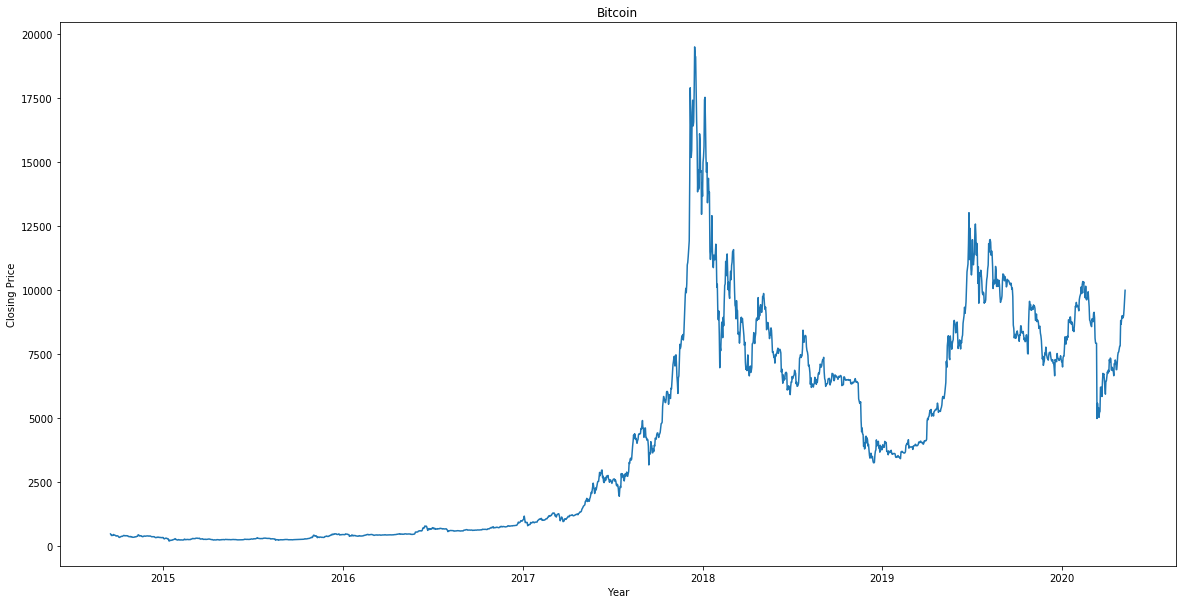

In [24]:
# Choose Stock and Period
stock= yf.Ticker("BTC-USD")
hist_data=stock.history(period='6y')

df=pd.DataFrame(hist_data['Close'])
df.index= pd.to_datetime(df.index,format='%Y-%m-%d')

df.dropna(how='any',inplace=True)
train_df=df[:int(0.8*len(df))]

test_df=df[int(0.8*len(df))-5:]




plt.figure(figsize=(20,10))
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('{}'.format(stock.info['name']))

pd.set_option('display.max_rows', 500)
pd.Series(stock.info)

                High      Low
Month_Year                   
2014-09       468.17   372.24
2014-10       411.70   289.30
2014-11       457.09   320.63
2014-12       384.04   304.23
2015-01       320.43   171.51
2015-02       265.61   212.01
2015-03       300.04   236.51
2015-04       261.80   214.87
2015-05       247.80   228.57
2015-06       267.87   221.30
2015-07       314.39   253.51
2015-08       285.71   199.57
2015-09       259.18   225.12
2015-10       334.17   235.62
2015-11       495.56   301.00
2015-12       469.10   349.46
2016-01       462.93   354.91
2016-02       448.05   367.96
2016-03       439.65   394.04
2016-04       467.96   415.83
2016-05       553.96   437.39
2016-06       777.99   525.64
2016-07       704.97   611.83
2016-08       626.12   531.33
2016-09       628.82   570.81
2016-10       720.40   609.48
2016-11       756.24   678.16
2016-12       979.40   746.05
2017-01      1191.10   755.76
2017-02      1200.39   946.69
2017-03      1280.31   903.71
2017-04   

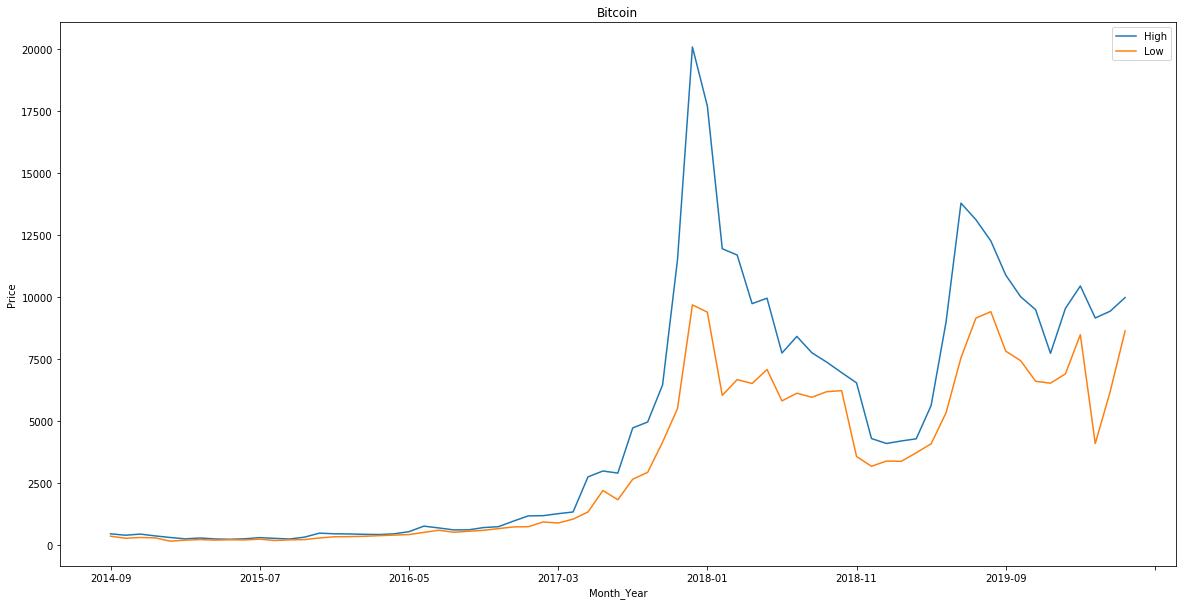

In [69]:
# Historical Data Maximum highs and Minimum Lows for each month
Data=hist_data
Data.dropna(inplace=True)
dating=hist_data.index.strftime('%Y-%m')
Data['Month_Year']=dating


# Highest of the High column
Highs=Data.groupby('Month_Year')['High'].max()
# Lowest of the Low column
Lows=Data.groupby('Month_Year')['Low'].min()
info=pd.merge(Highs, Lows, on="Month_Year")
print(info)
print(info['High'].max(axis=0))
print(info['Low'].min(axis=0))
info.plot(figsize=(20,10))
plt.title(stock.info['name'])
plt.ylabel('Price')
plt.show()


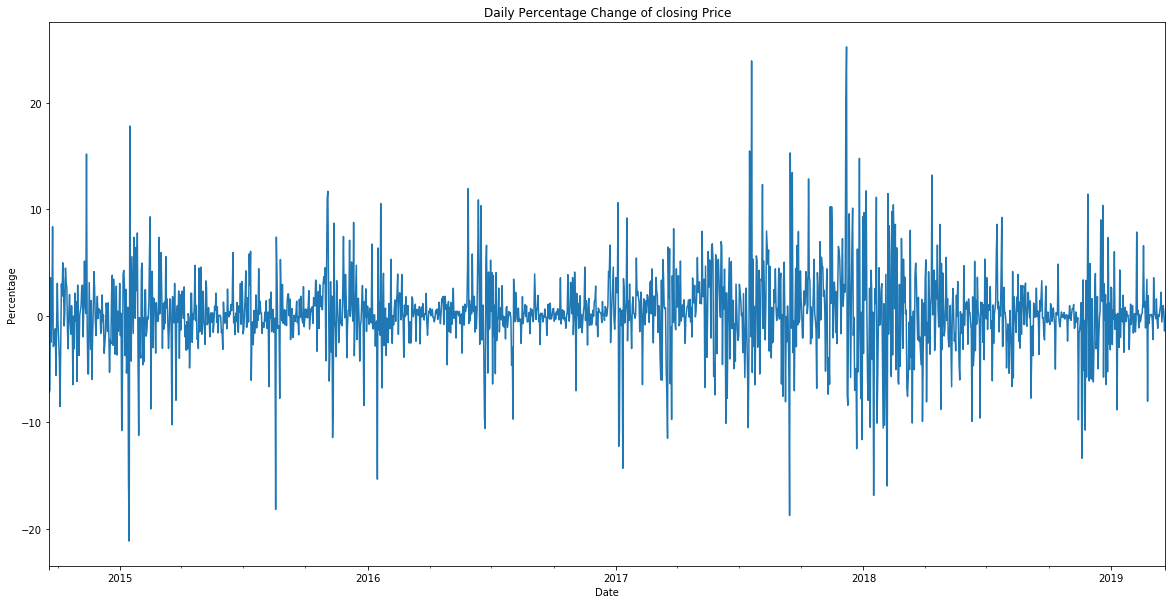

In [10]:
# Calculate Daily Percent change and Plot it against the Date

percentages=[]

for day in range(1,len(train_df)):
    # Percentage found by calculating the the day's and the day's before closing price 
    # Positive percentage means the day's closing price is higher than the day's before closing price
    
    percentages.append( 100* (train_df['Close'][day]-train_df['Close'][day-1])/train_df['Close'][day-1])
    
perc_change=pd.Series(percentages, index=train_df.index[1:])
perc_change
plt.figure(figsize=(20,10))
perc_change.plot()
plt.title('Daily Percentage Change of closing Price')
plt.ylabel('Percentage')
plt.show()

The r2 score is 0.9911094091593937
The mean absolute percentage error is 3.26


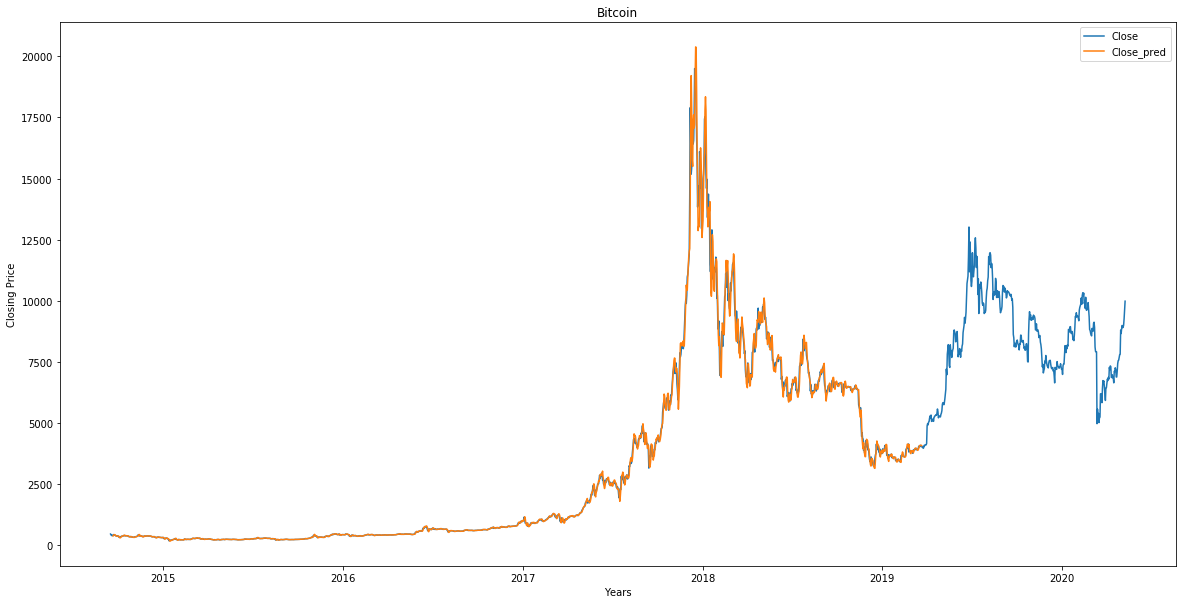

In [101]:
# Number of past days used for predicition
N=5
train_dates=train_df.index
train_close=pd.DataFrame()
pred_close=[]
dates=[]
slopes=[]
variance=[]
percents=[]
buy=[]
sell=[]

for i in range(N,len(train_df)):
    X_train = np.array(range(N)) 
    y_train = np.array(train_df[i-N:i])
    
    # Find Percentage change of Closing Value to find the outliers for buying and selling dates
    
    flat=y_train.flatten()
    diff=np.diff(flat)/flat[:len(flat)-1]*100
    mean= np.mean(diff)
    percents.append(mean)
    stdev=np.std(diff)

    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
   # Train the model
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)            
    y_pred = regr.predict(np.array(N).reshape(1,-1))
    dates.append(train_df.index[i])
    pred_close.append(y_pred[0][0])
    slopes.append(regr.coef_[0][0])
    variance.append(np.var(y_train))
    # Care about the most recent percentage change
    # Get the Buy Dates when the last percentage change is below the acceptable range
    # Get the Sell Dates when the Last Percentage change is above the acceptable range
    # Want the Dates where there is the biggest percentage changes
    if diff[-1] < 0 and diff[-1] < mean-stdev and regr.coef_ <0:
        buy.append(train_df.index[i])
       
    elif diff[-1] >0 and  diff[-1] > mean+stdev and regr.coef_>0:
        sell.append(train_df.index[i])
    

train_close['Close_pred']=pred_close
train_close['Date']=dates
train_close=train_close.set_index('Date')

merge=df.join(train_close).copy()

plt.figure(figsize=(20,10))



# Compute Mean Absolute Percent Error and R2 score

y_true, y_pred = np.array(train_df['Close'][5:]), np.array(train_close['Close_pred'])
r2=r2_score(y_true, y_pred)
mape= np.around(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, decimals=2)

print('The r2 score is {}'.format(r2))
print('The mean absolute percentage error is {}'.format(mape))



plt.plot(merge)
plt.title('{}'.format(stock.info['name']))
plt.xlabel('Years')
plt.ylabel('Closing Price')
plt.legend(merge)



plt.show()


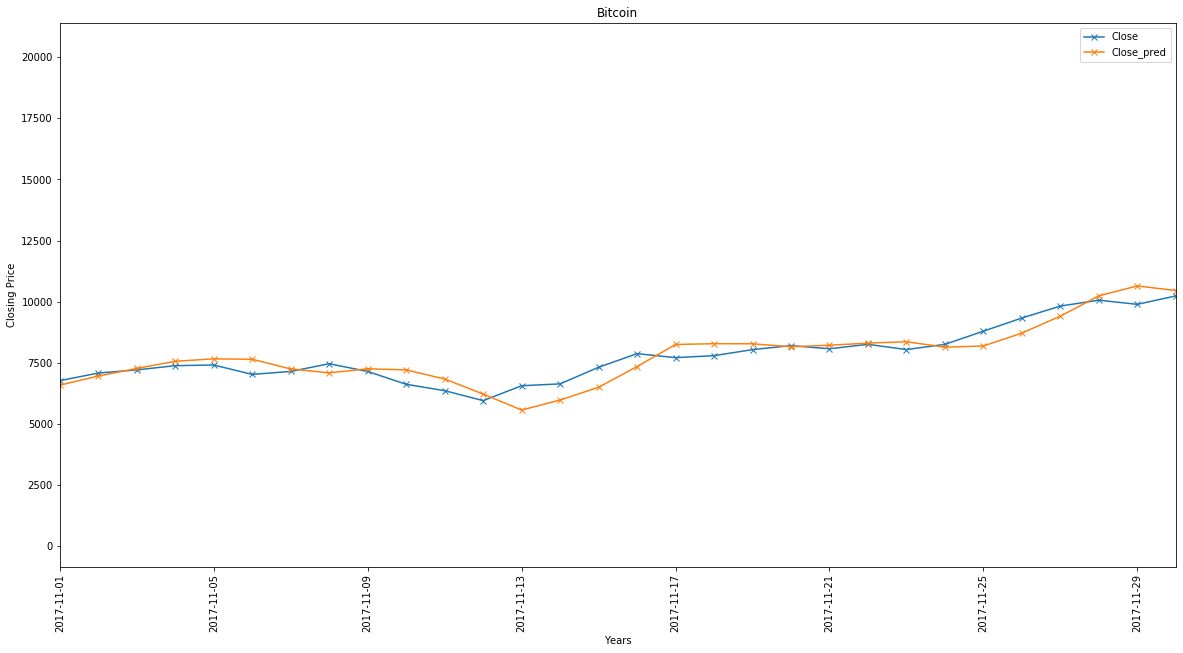

In [87]:
# Zoom in on plotplt.plot(merge)
plt.figure(figsize=(20,10))
plt.plot(merge, marker='x')
plt.title('{}'.format(stock.info['name']))
plt.xlabel('Years')
plt.xlim([datetime.date(2017, 11, 1), datetime.date(2017, 11, 30)])
plt.xticks(rotation='vertical')
plt.ylabel('Closing Price')
plt.legend(merge)
plt.show()

If stocks were bought based on the buy dates, the average difference between the true value and predicted 
value would be $-24.39 with a standard deviation of 356.57
      
If stocks were sold based on the sell dates, the average difference between the true value and predicted
value would be $39.81 with a standard deviation of 395.13
      
The average amount of days in between the buy dates is 12
The average amount of days in between the sell dates is 9


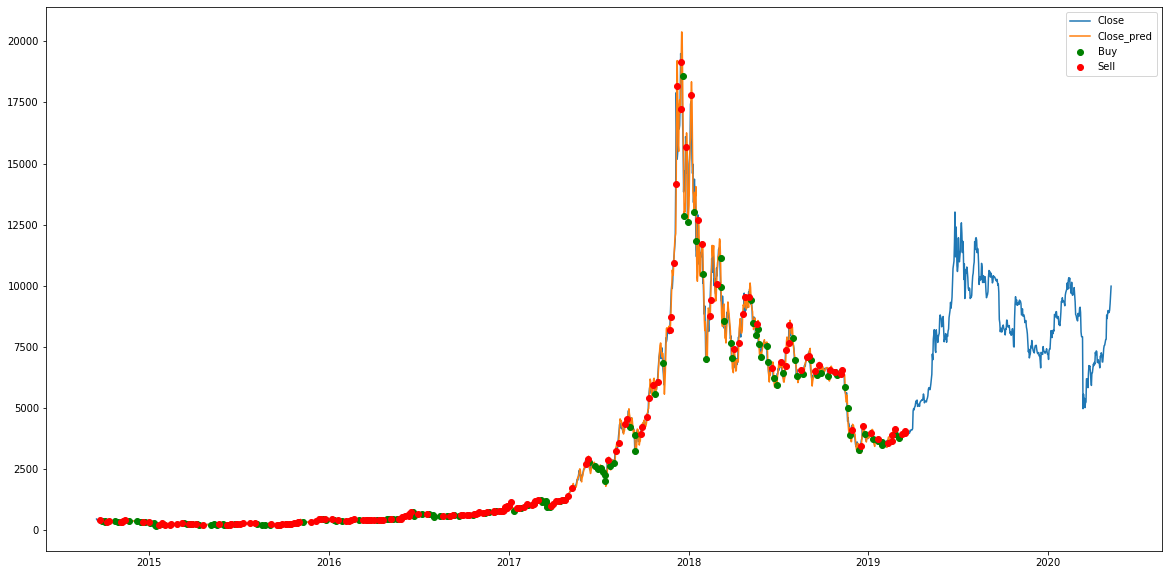

In [116]:
# Plot the buy and sell dates on the Closing Predictions

def certaindates(data, buylist,selllist,column,xbound='insert here'):
    buyprices=[]
    sellprices=[]
    
    for x in buylist:
        buyprices.append(column[data.index==x].values[0])
        
    for y in selllist:
        sellprices.append(column[data.index==y].values[0])
        
    fig, ax = plt.subplots(figsize=(20,10))
         
    
    ax.plot(data.index,data['Close'])
    ax.plot(data.index,column)
    ax.plot(buylist,buyprices , 'go')
    ax.plot(selllist,sellprices,'ro')
    ax.legend(['Close','Close_pred','Buy','Sell'])
    if type(xbound)==list:   
        plt.xticks(rotation=45)
        ax.set_xlim(xbound)
buyavg=[merge['Close'][merge.index==x].values[0]-merge['Close_pred'][merge.index==x].values[0] for x in buy]
sellavg=[merge['Close'][merge.index==x].values[0]-merge['Close_pred'][merge.index==x].values[0] for x in sell]

# Know stocks  are usually bought and sold between opening and closing time
# For this instance, the transaction will be based on closing price
# Positive average difference means true values were on average higher than that of the predicted values

print('''If stocks were bought based on the buy dates, the average difference between the true value and predicted 
value would be ${} with a standard deviation of {}
      '''.format(round(np.mean(np.array(buyavg)),2), round(np.std(np.array(buyavg)),2)))
print('''If stocks were sold based on the sell dates, the average difference between the true value and predicted
value would be ${} with a standard deviation of {}
      '''.format(round(np.mean(np.array(sellavg)),2), round(np.std(np.array(sellavg)),2)))

certaindates(merge,buy,sell, merge.Close_pred)
print('The average amount of days in between the buy dates is '+ str(np.mean(np.diff(buy)).days))
print('The average amount of days in between the sell dates is '+ str(np.mean(np.diff(sell)).days))

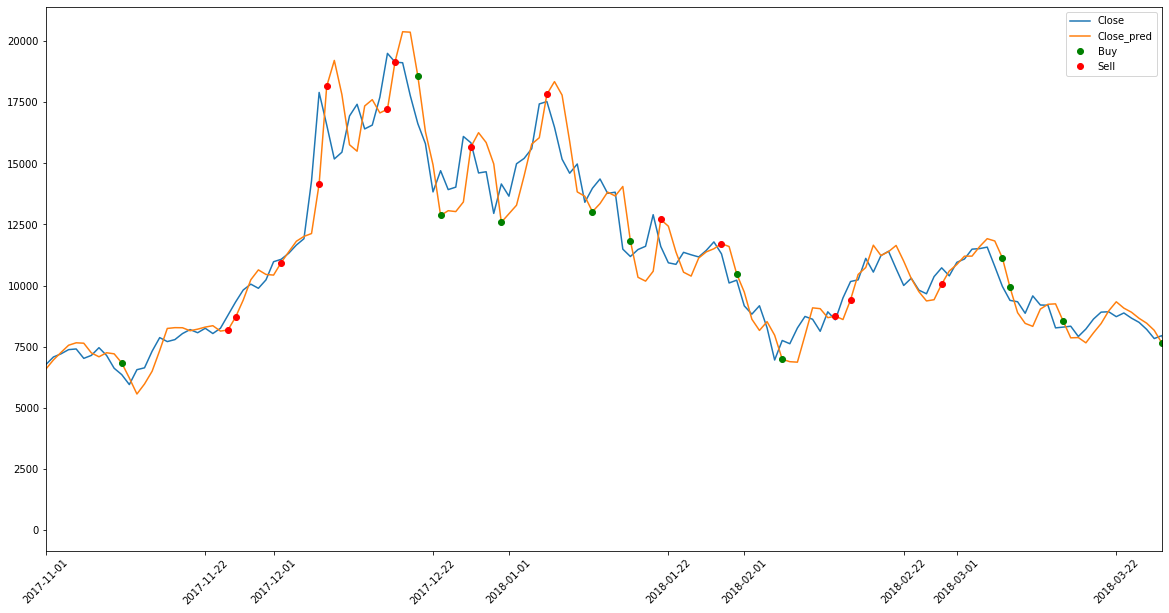

In [89]:
# Zoom in on plot
certaindates(merge,buy,sell, merge.Close_pred,[datetime.date(2017, 11, 1), datetime.date(2018, 3, 28)] )

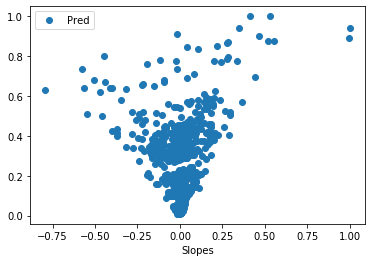

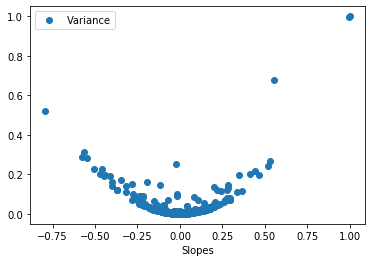

In [15]:
#Check relation of Variables
def relvar(x):
    # Normalize the data
    real=np.array(x)/np.max(x)
    slopes_normed = slopes / max(slopes)
    pred3=pred_close/ max(pred_close)
    varsw= variance/max(variance)
    pr= pd.DataFrame()
    # Add to Dataframe

    pr['Slopes']=slopes_normed
    pr['Real']=real
    pr['Pred']=pred3
    pr['Variance']=varsw
    pr.index=dates
    # Plot variables
    pr.plot(x='Slopes', y='Pred', style='o')
    pr.plot(x='Slopes', y='Variance', style='o')
    plt.show()
relvar(train_df['Close'][5:])

The r2 score is 0.9474143985752308
The mape is 3.4587682073880957
             Close  Close_pred  Test_Close_pred
Date                                           
2014-09-17  457.33         NaN              NaN
2014-09-18  424.44         NaN              NaN
2014-09-19  394.80         NaN              NaN
2014-09-20  408.90         NaN              NaN
2014-09-21  398.82         NaN              NaN
2014-09-22  402.15     377.090              NaN
2014-09-23  435.79     393.654              NaN
2014-09-24  423.20     430.661              NaN
2014-09-25  411.57     433.443              NaN
2014-09-26  404.42     428.271              NaN
              Close  Close_pred  Test_Close_pred
Date                                            
2020-04-28  7807.06         NaN         7863.425
2020-04-29  8801.04         NaN         7902.068
2020-04-30  8658.55         NaN         8707.519
2020-05-01  8864.77         NaN         9037.264
2020-05-02  8988.60         NaN         9282.353
2020-05-03  889

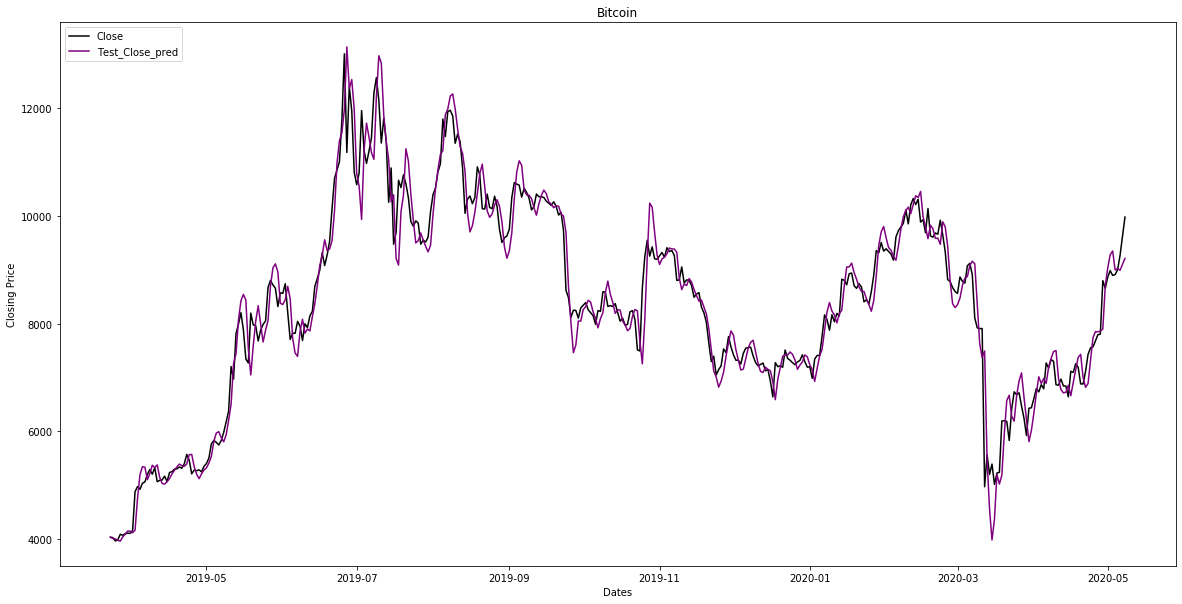

In [107]:
# Get predicition for test dataset
pred_testclose=[]
dates1=[]
buy1=[]
sell2=[]
test_dates=test_df.index
test_close=pd.DataFrame()
for i in range(N,len(test_df)):
    X_test = np.array(range(N)) 
    y_test = np.array(test_df[i-N:i]) 
    X_test = X_test.reshape(-1, 1)     
    y_test = y_test.reshape(-1, 1)
   # Train the model


    flat=y_test.flatten()
    diff=np.diff(flat)/flat[:len(flat)-1]*100
    mean= np.mean(diff)
    percents.append(mean)
    stdev=np.std(diff)
    
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_test, y_test)            
    test_pred = regr.predict(np.array(N).reshape(1,-1))
    dates1.append(test_df.index[i])
    pred_testclose.append(test_pred[0][0])
    # Get buy and sell dates
    if diff[-1] < 0 and diff[-1] < mean-stdev and regr.coef_ <0:
        buy1.append(test_df.index[i])
    
    elif diff[-1] >0 and  diff[-1] > mean+stdev and regr.coef_ >0:
        sell2.append(test_df.index[i])
        
test_close['Test_Close_pred']=pred_testclose
test_close['Date']=dates1
test_close=test_close.set_index('Date')

result=merge.join(test_close, how='outer')

# Compute the Mean Absolute Percent Error for the test set

y_true1, y_pred1 = np.array(test_df['Close'][5:]), np.array(test_close['Test_Close_pred'])
r2_1=r2_score(y_true1,y_pred1)
mape1= np.mean(np.abs((y_true1 - y_pred1) / y_true1)) * 100
# Print Mape and R2 score
print('The r2 score is {}'.format(r2_1))
print('The mape is {}'.format(mape1))

plt.figure(figsize=(20,10))
plt.plot(result.index[int(0.8*len(df)):],result['Close'][int(0.8*len(df)):], color='black', label='Close')
plt.plot(result.index[int(0.8*len(df)):], result['Test_Close_pred'][int(0.8*len(df)):], color='purple', label='Test_Close_pred')
plt.legend(loc="upper left")
plt.title(stock.info['name'])
plt.xlabel('Dates')
plt.ylabel('Closing Price')
print(result.head(10))
print(result.tail(10))

If stocks were bought based on the buy dates, the average difference between the true value and predicted 
value would be $-13.05 with a standard deviation of 327.97
      
If stocks were sold based on the sell dates, the average difference between the true value and predicted
value would be $110.96 with a standard deviation of 429.3
      
The average amount of days in between the buy dates is 8
The average amount of days in between the sell dates is 8


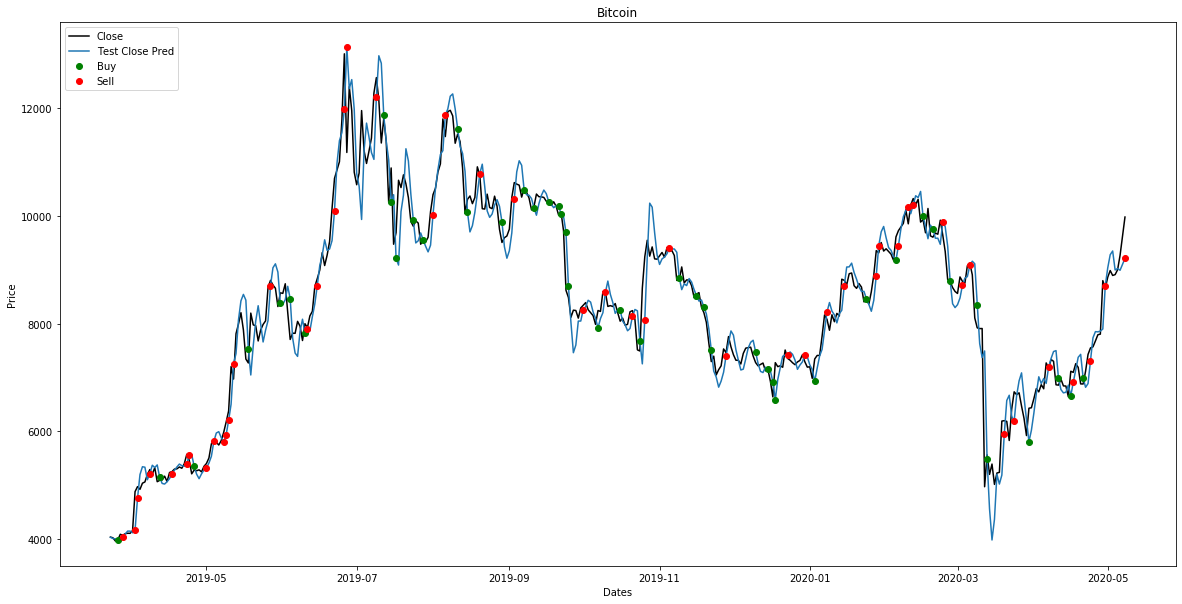

In [118]:
# Get buying and selling dates for test set


def newestdates(data, buylist,selllist,column, date='change date'):
    buyprices=[]
    sellprices=[]
    for x in buylist:
        buyprices.append(column[data.index==x].values[0])
    for y in selllist:
        sellprices.append(column[data.index==y].values[0])
    plt.figure(figsize=(20,10))
    plt.plot(data.index[int(0.8*len(df)):], data['Close'][int(0.8*len(df)):], color='black', label='Close')
    plt.plot(data.index[int(0.8*len(df)):],column[int(0.8*len(df)):], label='Test Close Pred')
    plt.plot(buylist,buyprices , 'go', label='Buy')
    plt.plot(selllist,sellprices,'ro', label='Sell')
    if type(date)==list:
        plt.xlim(date)
    plt.legend(loc="upper left")
    plt.title(stock.info['name'])
    plt.xlabel('Dates')
    plt.ylabel('Price')
    plt.show()

# Positive average differences  mean that on average the difference between the true value and predicted value if positive
# so the true values would be on average larger than the predcited value and vice versa for the negative averages


buy1avg=[result['Close'][result.index==x].values[0]-result['Test_Close_pred'][result.index==x].values[0] for x in buy1]
sell2avg=[result['Close'][result.index==x].values[0]-result['Test_Close_pred'][result.index==x].values[0] for x in sell2]
    
print('''If stocks were bought based on the buy dates, the average difference between the true value and predicted 
value would be ${} with a standard deviation of {}
      '''.format(round(np.mean(np.array(buy1avg)),2), round(np.std(np.array(buy1avg)),2)))
print('''If stocks were sold based on the sell dates, the average difference between the true value and predicted
value would be ${} with a standard deviation of {}
      '''.format(round(np.mean(np.array(sell2avg)),2), round(np.std(np.array(sell2avg)),2)))
   
print('The average amount of days in between the buy dates is '+ str(np.mean(np.diff(buy1)).days))
print('The average amount of days in between the sell dates is '+ str(np.mean(np.diff(sell2)).days))
newestdates(result,buy1,sell2, result.Test_Close_pred)

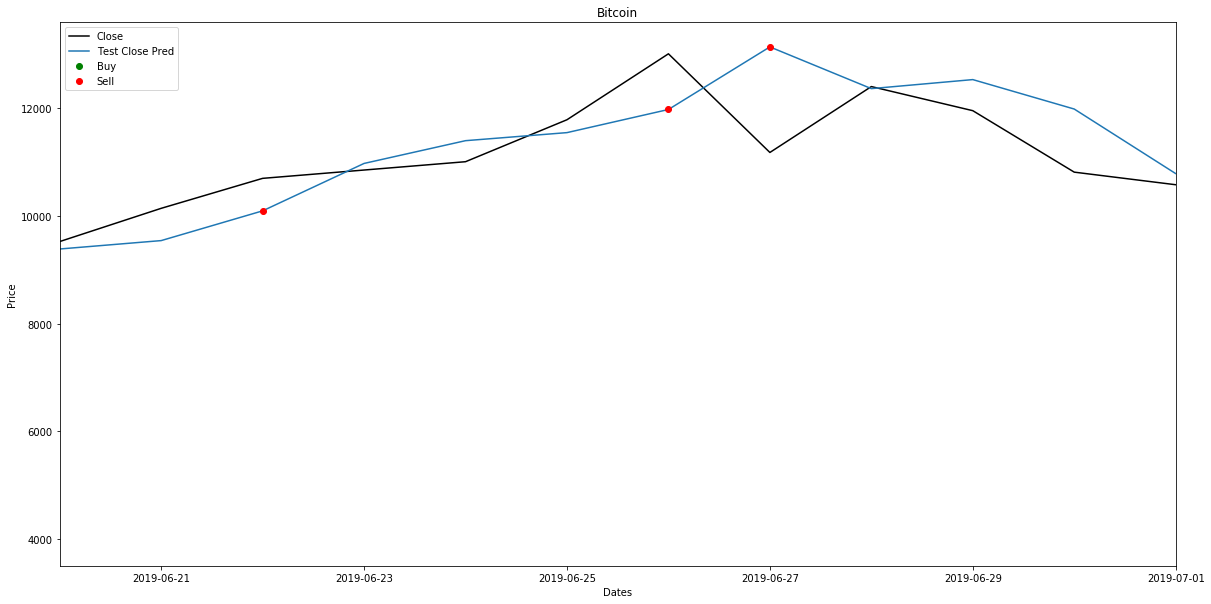

In [104]:
# Zoom in on plot
# Dates can be altered
newestdates(result,buy1,sell2, result.Test_Close_pred,[datetime.date(2019, 6,20 ), datetime.date(2019, 7, 1)])